<a href="https://colab.research.google.com/github/ThePingPing/Torch_Model_Colab/blob/main/AdvanceGan'sModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seconde Step TO DONE

1) - The Model gonna take in input face imaages

2) - The Model is A Gan's Model

3) - The output to Generate a new Face

In [ ]:
!pip install torchinfo
!pip install tqdm
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.1/281.1 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.4 MB/s eta 0:00:00


In [ ]:
import torch
import pdb
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torchinfo import summary
from torch.optim import Adam, SGD
from torchvision import datasets
from torchvision.datasets import ImageFolder, MNIST
from torchvision.utils import make_grid

import torchvision.transforms as Tr

from torch.utils.data import Dataset, DataLoader, TensorDataset

import numpy as np
import pandas as pd
import random
from tqdm.auto import tqdm

import PIL
from PIL import Image


from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles

import time
import requests
import zipfile
import os
from pathlib import Path
import wandb


import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def show(tensor, wanbd = 0, num=25, name = ""):
  ## wanbd -- > weight and Bias

  data = tensor.detach().cpu()
  grid = make_grid(data[:num], nrow=5).permute(1, 2, 0) ## pytorch --> (channel, H, W) --> plt (W, H, Channel)

  if (wanbd == 1 and wandbact == 1):
    wandb.log({name:wandb.Image(grid.np.clip(0, 1))})

  plt.imshow(grid.clip(0, 1))
  plt.show()

In [ ]:
## Constant Section Data

number_epochs = 1000
batch_size = 128
noise_dim = 200 ## noise Vector --> z_dim
out_dim = 16 # wew build the Gen Desc base on that




In [ ]:
## Constant Section Model

number_epochs = 1000
learning_rate = (10 ** -4)

curr_step = 0
critic_cycle = 5 ## --> 5 cycle learning , to 1 cycle generate

gen_loss = []
critic_loss = []

show_step = 30
save_point = 30

wandbact = 1 ## i want to tracking the Stat Values

# loss_func = nn.BCEWithLogitsLoss()


In [ ]:
!pip install wandb -qqq
import wandb
wandb.login(key="b64fc7a7ef553bb2578afe3d1e06be827a988107")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
%%capture
experiment_name = wandb.util.generate_id() ## generate The name for this specifics Experiment

my_run = wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",

    # track hyperparameters and run metadata
    config={
    # "learning_rate": 0.02,
    "optimizer" : "adam",
    "model" : "wang gp",
    # "architecture": "CNN",
    # "dataset": "CIFAR-100",
    "batch_size": 128,
    "epochs": 1000,
    }
)

confib = wandb.config


In [ ]:
print(experiment_name)

31b5hp27


In [ ]:
class Generator(nn.Module):

    def __init__(self, input_shape : int ,output_shape : int) -> None :
      super(Generator, self).__init__()

      ## First Block

      self.gen = nn.Sequential(
          ## ConvTranspose2d
          ## next_input = (n-1) * stride - (2*padding) + kernel_size
          nn.ConvTranspose2d(in_channels= input_shape, out_channels=output_shape * 32,
                             kernel_size= 4, stride=1, padding=0), ## new size --> 4x4 (chanell: (200, 512))

          nn.BatchNorm2d(output_shape * 32),
          nn.ReLU(True),

          nn.ConvTranspose2d(in_channels= output_shape * 32, out_channels=output_shape * 16,
                             kernel_size= 4, stride=2, padding=1),  ## new size --> 8x8 (chanell: (512, 256))

          nn.BatchNorm2d(output_shape * 16),
          nn.ReLU(True),


          nn.ConvTranspose2d(in_channels= output_shape * 16, out_channels=output_shape * 8,
                             kernel_size= 4, stride=2, padding=1), ## new size --> 16x16 (chanell: (256, 128))

          nn.BatchNorm2d(output_shape * 8),
          nn.ReLU(True),

          nn.ConvTranspose2d(in_channels= output_shape * 8, out_channels=output_shape * 4,
                             kernel_size= 4, stride=2, padding=1), ## new size --> 32x32 (chanell: (128, 64))

          nn.BatchNorm2d(output_shape * 4),
          nn.ReLU(True),

          nn.ConvTranspose2d(in_channels= output_shape * 4, out_channels=output_shape * 2,
                             kernel_size= 4, stride=2, padding=1), ## new size --> 64x64 (chanell: (64 ,32))

          nn.BatchNorm2d(output_shape * 2),
          nn.ReLU(True),

          nn.ConvTranspose2d(in_channels= output_shape * 2, out_channels=3,
                             kernel_size= 4, stride=2, padding=1), ## new size --> 128x128 (chanell: (32 ,3)) --> OUTPUT LAYER

          nn.Tanh(), ## Normalize beetween [-1, 1]
      )

    def forward(self, noise):
      x = self.gen(noise).view(len(noise), self.input_shape, 1, 1)
      return self.gen(x)

def gen_noise(number, noise_dim : int):
  return torch.randn(number, noise_dim).to(device)


In [ ]:
class Critic(nn.Module):

  def __init__(self, output_shape : int):
     super(Critic, self).__init__()

     self.critic = nn.Sequential(
         ## Conv2d
         ## next_input = (n+2) *padding) - kernel_size) / (stride) +1

         nn.Conv2d(in_channels=3, out_channels=output_shape, kernel_size=4, stride=2, padding=1), ## (128 + 2 - 4) // 2 +1 = 64x64 (channel: (3, 16= pass in param))
         nn.InstanceNorm2d(num_features = output_shape),
         nn.LeakyReLU(0.2),


         nn.Conv2d(in_channels=output_shape, out_channels= 2 * output_shape, kernel_size=4, stride=2, padding=1), ## 32x32 (channel: (16, 32))
         nn.InstanceNorm2d(num_features = 2 * output_shape),
         nn.LeakyReLU(0.2),


         nn.Conv2d(in_channels=output_shape * 2, out_channels= 4 * output_shape, kernel_size=4, stride=2, padding=1), ## 16x16 (channel: (32, 64))
         nn.InstanceNorm2d(num_features = 4 * output_shape),
         nn.LeakyReLU(0.2),


         nn.Conv2d(in_channels=output_shape * 4, out_channels= 8 * output_shape, kernel_size=4, stride=2, padding=1), ## 8x8 (channel: (64, 128))
         nn.InstanceNorm2d(num_features = 8 * output_shape),
         nn.LeakyReLU(0.2),


         nn.Conv2d(in_channels=output_shape * 8, out_channels= 16 * output_shape, kernel_size=4, stride=2, padding=1), ## 4x4 (channel: (128, 256))
         nn.InstanceNorm2d(num_features = 16 * output_shape),
         nn.LeakyReLU(0.2),


         nn.Conv2d(in_channels=output_shape * 16, out_channels= 1, kernel_size=3, stride=1, padding=0), ## 8x8 (channel: (64, 128))
     )

  def forward(self, image):
    x = self.critic(image).view(len(image), -1)
    return x




In [ ]:
## Constant Get Data and downloading

import gdown, zipfile

## https://drive.google.com/file/d/0B7EVK8r0v71pZjFTYXZWM3FlRnM/view?usp=drive_link&resourcekey=0-dYn9z10tMJOBAkviAcfdyQ

URL = "https://drive.google.com/file/d/0B7EVK8r0v71pZjFTYXZWM3FlRnM/view?usp=drive_link&resourcekey=0-dYn9z10tMJOBAkviAcfdyQ"
PATH = "data/celeba"
DATA_PATH = f'{PATH}/img_align_celeba.zip'



if not os.path.exists(PATH):
  os.makedirs(PATH)

!mv '/content/drive/MyDrive/DataSet/img_align_celeba.zip' '/content/data/celeba'

# gdown.download(URL, DOWNLOAD_PATH, quiet = False)

with zipfile.ZipFile(DATA_PATH, 'r') as myzip:
  myzip.extractall(PATH)


mv: cannot stat '/content/drive/MyDrive/DataSet/img_align_celeba.zip': No such file or directory


KeyboardInterrupt: 

# We are Down to Download the Data Set

1) - Now Convert to Dataloader

2) - Create the Gradient Penality base on aging

3) - Create the train loop model

In [ ]:
class CelebaData(Dataset):

  def __init__(self, path:str, size:int, limit:int):

    self.sizes = [size, size]
    items_list, lables_list = [], []

    for data in os.listdir(path)[:limit]:
      item = os.path.join(path, data)
      items_list.append(item)
      lables_list.append(data)

    self.items = items_list
    self.labels = lables_list

  def __len__(self):
    return len(self.items)

  def __getitem__(self, index):
    data = Image.open(self.items[index]).convert('RGB')
    data = np.asarray(Tr.Resize(self.sizes)(data)) ## Data = (128, 128, 3)
    data = np.transpose(data, (2, 0, 1)).astype(np.float32, copy=False)
    data = torch.from_numpy(data).div(255) ## normalization
    return data, self.labels[index]



In [ ]:
## init the Data

lim = 10 ** 4
data_path = '/content/data/celeba/img_align_celeba'
image_size = 128

data_celeba = CelebaData(path=data_path, size=image_size, limit=lim)


In [ ]:
print(type(data_celeba))

In [ ]:
def dataloarder_convert(data:CelebaData, batch_size:int):
  celeba_loarder = DataLoader(data, batch_size=batch_size, shuffle=True)
  return celeba_loarder

In [ ]:
celeba_loarder = dataloarder_convert(data = data_celeba, batch_size = 128)

In [ ]:
def init_gen_critic():
  gen = Generator(input_shape = noise_dim , output_shape = out_dim).to(device)
  critic = Critic(output_shape = out_dim)

  optim_gen = Adam(gen.parameters(), lr=learning_rate, betas=(0.5, 0.9))
  optim_critic = Adam(critic.parameters(), lr=learning_rate, betas=(0.5, 0.9))

  return gen, critic, optim_gen, optim_critic

In [ ]:
gen, critic, optim_gen, optim_critic  = init_gen_critic()

In [ ]:
def teste_show_data(data:DataLoader):
  X, y = next(iter(data))
  show(X)

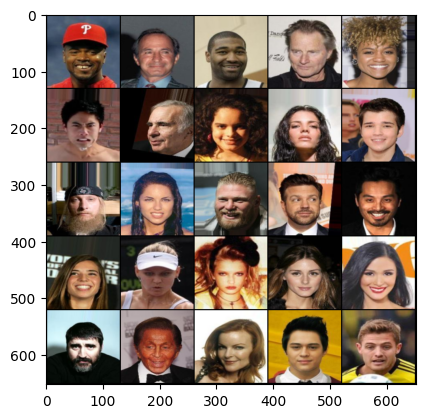

In [ ]:
teste_show_data(data = celeba_loarder)

# Nice Now The Data set It's READY

1) - we gonna Implemente the Gardiente penality (with the aging formula)

2) - def a function computing panality gardient

In [ ]:
def computing_grad_penality(Crit : nn.Module, real, fake, alpha : torch.Tensor, gamma = 10):

  mix_imgs = alpha * real + (1-alpha) * fake
  mix_scores = Crit(mix_imgs)

  gradient = torch.autograd.grad(
      inputs = mix_imgs,
      outputs = mix_scores,
      grad_outputs= torch.ones_like(mix_scores),
      retain_graph=True,
      create_graph=True,
  ) ##--> (128, 3, 128, 128) --> (Batch_size, Channel, H_img, W_img)

  gradient = gradient.view(len(gradient), -1) ## reduice dim to Matrix
  gradient_nomr = gradient.norm(2, dim=1) ##--> || u ||L(2)

  grad_penality = gamma * ((gradient_nomr - 1) **2 ).mean()

  return grad_penality


# we Expecting to have a long learning Session
1) - def a function save on the checkpoint

2) - def a function to load on the checkpoint



In [ ]:
## gen, critic, optim_gen, optim_critic
root_path = "/content/data/"

def save_checkpoint(name: str, epoch:int):

  torch.save({
      "epoch": epoch,
      "model_state_dict": gen.state_dict(),
      "optimizor_state_dict": optim_gen.state_dict(),

  }, f'{root_path}Gen-{name}.pkl')

  torch.save({
    "epoch": epoch,
    "model_state_dict": critic.state_dict(),
    "optimizor_state_dict": optim_critic.state_dict(),

}, f'{root_path}Critic-{name}.pkl')

  print("Save Checkpoint")

def load_checkpoint(name: str):

  ########## Load Generator from file ##################
  checkpoint = torch.load(f'{root_path}Gen-{name}.pkl') ## load the File
  gen.load_state_dict(checkpoint["model_state_dict"])
  optim_gen.load_state_dict(checkpoint["optimizor_state_dict"])

   ########## Load Critic from file ##################

  checkpoint = torch.load(f'{root_path}Critic-{name}.pkl') ## load the File
  critic.load_state_dict(checkpoint["model_state_dict"])
  optim_critic.load_state_dict(checkpoint["optimizor_state_dict"])

  print(" Load Checkpoint ")


In [ ]:
# save_checkpoint(name = "test_save", epoch = 1)
load_checkpoint(name = "test_save")

 Load Checkpoint 


# Good The Save and Load is define

1) - Build the Trainig loop

In [ ]:
def train_step(loss_function : nn.Module, optim_disc : torch.optim.Optimizer, optim_gen : torch.optim.Optimizer , dataloader : DataLoader, number_epochs : int ,device: torch.device):

  ## gen, critic, optim_gen, optim_critic
  mean_gen_loss = 0

  for epochi in range(number_epochs):
    for real , _ in tqdm(dataloader):
      curr_batch = len(real)
      real = real.to(device)

      ## Critic Section ##
      mean_critic_loss = 0
      for _ in range(critic_cycle):
        optim_critic.zero_grad()

        noise = gen_noise(curr_batch, noise_dim)
        fake = gen(noise)
        yHat_critic_fake = critic(fake.detach())
        yHat_critic_real = critic(real)
        alpha_rand = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
        grad_penality = computing_grad_penality(Crit=critic, real=real, fake=fake, alpha=alpha_rand)

        ## comput Loss

        critic_loss = yHat_critic_fake.mean() - yHat_critic_real().mean() + grad_penality
        mean_critic_loss += critic_loss.item() / critic_cycle

        critic_loss.backward(retain_graph=True)
        optim_critic.step()

      critic_loss += [mean_critic_loss]

      ## Generator Section ##
      optim_gen.zero_grad()
      noise = gen_noise(curr_batch, noise_dim)
      fake = gen(noise)
      yHat_critic_fake = critic(fake)

      gen_loss = - yHat_critic_fake.mean()
      gen_loss.backward()
      optim_gen.step()

      gen_loss += [gen_loss.item()]

